In [761]:
import os
import codecs
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#bokeh for plotting
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#for creating wordcloud
from wordcloud import WordCloud, STOPWORDS


from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

import re
import spacy

#initiate spacy with english language
nlp = spacy.load('en_core_web_sm')
from pattern.en import suggest
import nltk

#phrase modeling
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases , Phraser
import string
from nltk import pos_tag

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize
from gensim.models.word2vec import Text8Corpus
from gensim.models import Word2Vec

#LDA Topic Modeling
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
import pickle

#dimensionality reduction - visualization
from sklearn.manifold import TSNE

Loading BokehJS ...

# Natural Language Processing With Customer Reviews

## Initial Steps
- __1. Import data__
- __2. Set the data frame up to contain only reviews__
- __3. Clean the text and extract dates for index column__

In [639]:
df = pd.read_csv('visit_survey.csv')

reviews = pd.DataFrame(df.iloc[:, 1]).dropna().rename(columns = {'Unnamed: 1':'reviews'}).reset_index(drop = True)

#cut out first few rows that don't hold any info
reviews = reviews.iloc[17:, :].reset_index(drop = True)

#extract dates from text and make them the index
# (?P<Date>....) - named capturing group
# \d+ 1 or more digits
# (?:\/\d+){2} - non-capturing group repeating twice, where
# \/ - escaped forward slash
# {2} - repeater (two times)
reviews.index = reviews.reviews.str.extract(r'(?P<Date>\d+(?:\/\d+){2})', expand=False).apply(pd.to_datetime)

#remove dates and symbols in date strings from reviews with regex, strip all white space
reviews['reviews'].replace(regex=True,inplace = True, to_replace=r'\d|/|-',value=r' ')

#strip all whitespace to the left of the text, created through removing dates from reviews
reviews['reviews'] = reviews.reviews.str.lstrip()

reviews.head()

,reviews
Date,
2018-07-03,Front desk and check out staff are not nearly as nice as the professionals in the back. Check out lady acts like she doesn?t want to wait on you.
2018-07-03,Complete attention & care. More than expected!!
2018-07-03,"My doctor, Dr. Walcott was very professional and kind. All the employees that took care of me were very professional and efficient"
2018-07-03,All is great
2018-07-03,"Dr Venarsky is outstanding, as well as the staff. I had an insurance question, and Nicki was so helpful. You guys are greatly appreciated."


## Generating A Wordcloud From Reviews
- __Here I am going to create an overall wordcloud to see what the most common words are from the reviews__
- __While this will show the common words, it will not reflect the negative reviews most likely since those are mentioned less, so I want to parse those out eventually using sentiment analysis__

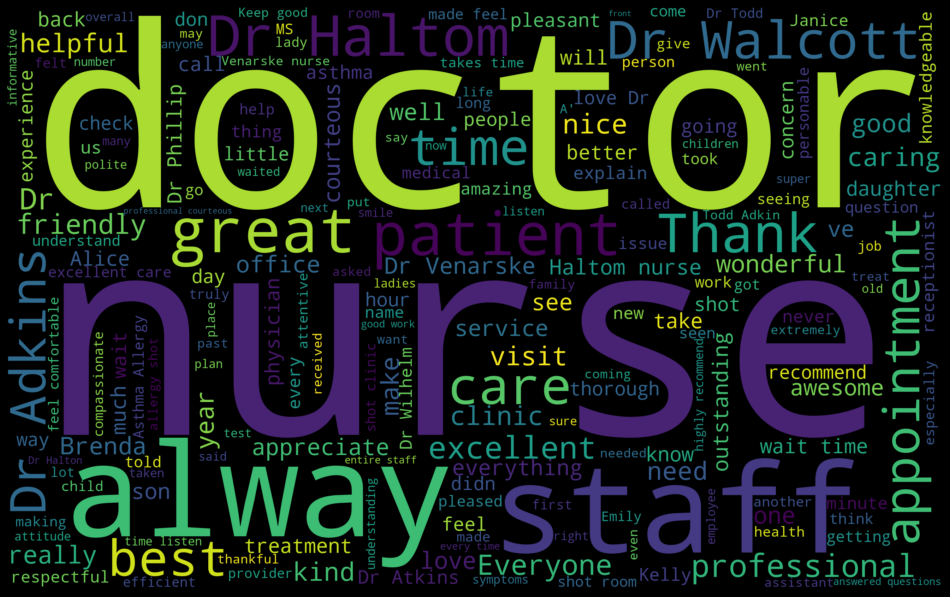

In [49]:
text = reviews.reviews.values
wordcloud = WordCloud(
    width = 2650,
    height = 1650,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (13, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

## Phrase and Topic Modeling
- I want to try and make sure that the text that is being tokenized will include phrases that should belong together as single tokens. For example, if New York City is in the corpus somewhere, I want the token to be New_York_City since those words are not independent from each other, they should be treated as one phrase. 
- I will be using lemmatization, stop word removal, and punctuation removal
- Big help here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [652]:
#get all reviews into list
data = list(reviews.reviews.values)

In [653]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [654]:
data_words = list(sent_to_words(data))

In [655]:
print(data_words[32])

['dr', 'haltom', 'has', 'been', 'one', 'of', 'my', 'he', 'best', 'drs', 'have', 'seen', 'to', 'keep', 'me', 'informed', 'of', 'test', 'results', 'and', 'outlook', 'would', 'highly', 'recommend', 'him', 'to', 'anyone']


In [656]:
# Build the bigram and trigram models
#the min_count determines if the model ignores all words and bigrams with total collected count lower than this value.
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count = 1, threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See bigram example
print(trigram_mod[bigram_mod[data_words[32]]])

['dr', 'haltom', 'has', 'been', 'one', 'of', 'my', 'he', 'best', 'drs', 'have', 'seen', 'to', 'keep', 'me', 'informed', 'of', 'test_results', 'and', 'outlook', 'would', 'highly_recommend', 'him', 'to', 'anyone']


In [657]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [658]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#see example of bigram
print(data_lemmatized[:1])

[['front_desk', 'check', 'staff', 'nearly', 'nice', 'professional', 'back', 'check', 'lady', 'act', 'want', 'wait']]


In [659]:
#take all of the lemmatized and trigrammed reviews and dump them into a new column
reviews['scrubbed_reviews'] = [x for x in data_lemmatized]

In [660]:
#convert column of lists to strings
reviews['scrubbed_reviews'] = reviews['scrubbed_reviews'].apply(', '.join)

#remove commas from strings
reviews['scrubbed_reviews'] = reviews['scrubbed_reviews'].str.replace(',','')

In [661]:
#looking at reviews that contain bigrams
reviews[reviews['scrubbed_reviews'].str.contains('_')].tail(10)

,reviews,scrubbed_reviews
Date,,
2019-11-29,"Recent visit with Dr. Adkins was informative and educational!! Thank you Dr. Adkins for explaining to me why I was having the symptoms , how it was different from an allergic response and how to avoid it .",recent_visit adkin informative educational thank adkin explain symptom different allergic response avoid
2019-12-04,Ms. Brenda is great. I appreciate her helping me to get some much needed nasal spray. Thank you Ms. Brenda for always having a beautiful smile and a beautiful attitude.,ms brenda great appreciate help get much need nasal_spray thank ms brenda always beautiful smile beautiful attitude
2019-12-05,The nurse was very apologetic for the extended wait time before seeing the doctor. Both the nurse and doctor were very kind and respectful to my son and myself. They were both professional and personable.,nurse apologetic extended_wait time see doctor nurse doctor kind respectful son professional personable
2019-12-27,The wait time on phone to make or cancel is way to long! I waited over minutes to cancel my apt and had to hang up to catch a work call! I called back several times to cancel and the same thing took place!,wait time phone make cancel way long wait minute cancel apt hang catch work call called_back several time cancel thing take place
2020-01-01,"Dr. Walcott is always very personable, attentive and thorough. I highly recommend him to my friends.",walcott always personable attentive thorough highly_recommend friend
2020-01-02,"My son's issues were addressed & I am very confident that everything is going to be resolved now! Also, the doctor was VERY thorough with examination! Would HIGHLY RECOMMEND",son issue address confident everything go resolve also doctor thorough examination would highly_recommend
2020-01-08,"Dr. Vernarske and all his staff are fantastic medical care providers,, from giving me allergy shots to helping me manage my allergies and newly diagnosed asthma! I feel I am getting treatment from the best! John Apidaca",vernarske staff fantastic medical care provider give allergy_shot help manage allergy newly diagnose asthma feel get treatment good john apidaca
2020-01-07,"Dr. Chelle Wilhelm is not only efficient at diagnosing your issues but she follows through in concern what changes you may have, if any and access what is best going forward. She's very pleasant and respectful, a great listener to your concerns. She's easy to reach and the staff is respectful and courteous and make sure your messages get to her if she's in clinic or out of the office. I'm pleased with overall service.",chelle wilhelm efficient diagnosing issue follow concern change may access best go forward pleasant respectful great listener concern easy reach staff respectful courteous make_sure message get clinic office please overall service
2020-01-08,"Dr. Wilhelm was excellent I loved her bedside manner, she was pleasant as easy to talk to, she explained her plan of care and didn’t force her treatments on you she allowed me to decide how I wanted my treatment to be carried out, I will definitely recommend her and her nurse was excellent also..",wilhelm excellent love bedside_manner pleasant easy talk explain plan care force treatment allow decide want treatment carry definitely_recommend nurse excellent also


In [586]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]


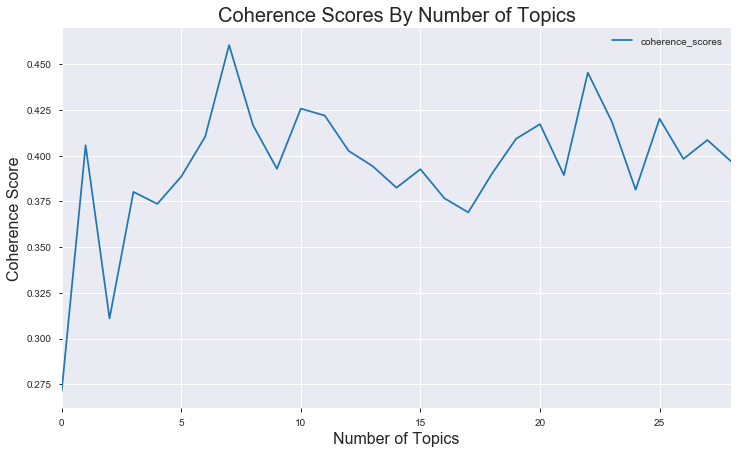

In [644]:
#how many topics should we have? We can use coherence scores to see which number of topics gives us the highest score, and use that in our final model
# Build LDA model
num_topics = list(range(1, 30))
models = []
for topic in num_topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topic, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    models.append(lda_model)
    
# Compute Coherence Score
coherence_scores = []
for model in models:
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_scores.append(coherence_model_lda.get_coherence())

#plot coherence scores and see which one makes the most sense (looks like 7 is the best)
pd.DataFrame(coherence_scores).rename(columns = {0:'coherence_scores'}).plot(figsize = (12, 7))
plt.ylabel('Coherence Score', fontsize = 16)
plt.xlabel('Number of Topics', fontsize = 16)
plt.title('Coherence Scores By Number of Topics', fontsize = 20);

In [630]:
#double check our topic number -- so we should use 7 topics
pd.DataFrame(coherence_scores).idxmax()

0    7
dtype: int64

In [631]:
# Build LDA model with 7 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [632]:
# Print the Keyword in the topics
lda_model.print_topics()
doc_lda = lda_model[corpus]

[(0,
  '0.067*"time" + 0.031*"really" + 0.031*"venarske" + 0.027*"take" + 0.025*"patient" + 0.021*"concern" + 0.020*"alice" + 0.019*"personable" + 0.019*"listen" + 0.017*"shot"'),
 (1,
  '0.031*"everything" + 0.029*"explain" + 0.025*"treatment" + 0.024*"knowledgeable" + 0.023*"year" + 0.018*"go" + 0.014*"change" + 0.014*"smile" + 0.012*"greet" + 0.012*"also"'),
 (2,
  '0.048*"walcott" + 0.045*"wait" + 0.042*"get" + 0.040*"appointment" + 0.032*"time" + 0.031*"professional" + 0.022*"doctor" + 0.020*"go" + 0.018*"need" + 0.017*"pleasant"'),
 (3,
  '0.078*"nurse" + 0.043*"care" + 0.034*"doctor" + 0.033*"always" + 0.033*"good" + 0.030*"make" + 0.030*"haltom" + 0.029*"adkin" + 0.025*"excellent" + 0.024*"thank"'),
 (4,
  '0.082*"staff" + 0.049*"great" + 0.032*"everyone" + 0.028*"best" + 0.027*"courteous" + 0.027*"allergy" + 0.024*"awesome" + 0.023*"clinic" + 0.022*"asthma" + 0.022*"thorough"'),
 (5,
  '0.027*"son" + 0.027*"way" + 0.025*"check" + 0.020*"would" + 0.019*"ms" + 0.016*"visit" + 0.

In [633]:
# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

In [634]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
3     0.35  0.04   1       1       33.23
2     -0.03 0.21   2       1       17.66
4     0.02  -0.27  3       1       13.03
0     -0.05 0.01   4       1       11.75
1     -0.09 -0.04  5       1       9.02 
5     -0.10 0.03   6       1       8.48 
6     -0.10 0.02   7       1       6.83 , topic_info=     Category   Freq                  Term  Total  loglift  logprob
45    Default 185.00  nurse                185.00 30.00    30.00   
8     Default 83.00   staff                83.00  29.00    29.00   
84    Default 98.00   time                 98.00  28.00    28.00   
21    Default 101.00  great                101.00 27.00    27.00   
12    Default 101.00  care                 101.00 26.00    26.00   
9     Default 56.00   wait                 56.00  25.00    25.00   
20    Default 65.00   walcott              65.00  24.00    24.00   
53    Default 52.00   appointment          52.00  23.00    23.00   
119   Default 67.00   get                  67.00  22.00    22.00   
41    Default 71.00   make                 71.00  21.00    21.00   
173   Default 70.00   haltom               70.00  20.00    20.00   
130   Default 25.00   answer               25.00  19.00    19.00   
46    Default 91.00   always               91.00  18.00    18.00   
15    Default 107.00  doctor               107.00 17.00    17.00   
49    Default 30.00   everyone             30.00  16.00    16.00   
87    Default 70.00   adkin                70.00  15.00    15.00   
66    Default 82.00   good                 82.00  14.00    14.00   
37    Default 58.00   excellent            58.00  13.00    13.00   
19    Default 58.00   take                 58.00  12.00    12.00   
144   Default 26.00   venarske             26.00  11.00    11.00   
7     Default 53.00   professional         53.00  10.00    10.00   
167   Default 31.00   really               31.00  9.00     9.00    
279   Default 26.00   best                 26.00  8.00     8.00    
28    Default 27.00   question             27.00  7.00     7.00    
183   Default 20.00   everything           20.00  6.00     6.00    
65    Default 45.00   go                   45.00  5.00     5.00    
38    Default 50.00   feel                 50.00  4.00     4.00    
48    Default 27.00   courteous            27.00  3.00     3.00    
52    Default 27.00   allergy              27.00  2.00     2.00    
82    Default 60.00   thank                60.00  1.00     1.00    
45    Topic1  184.34  nurse                185.19 1.10     -2.55   
12    Topic1  100.25  care                 101.19 1.09     -3.15   
41    Topic1  71.13   make                 71.80  1.09     -3.50   
173   Topic1  70.16   haltom               70.83  1.09     -3.51   
38    Topic1  49.42   feel                 50.09  1.09     -3.86   
37    Topic1  58.01   excellent            58.85  1.09     -3.70   
18    Topic1  41.20   kind                 41.86  1.09     -4.04   
180   Topic1  42.02   brenda               42.71  1.09     -4.02   
139   Topic1  39.13   friendly             39.81  1.08     -4.10   
24    Topic1  36.02   helpful              36.69  1.08     -4.18   
31    Topic1  45.25   love                 46.33  1.08     -3.95   
193   Topic1  26.38   wonderful            27.04  1.08     -4.49   
293   Topic1  25.13   help                 25.80  1.08     -4.54   
54    Topic1  23.73   appreciate           24.40  1.07     -4.60   
310   Topic1  23.27   phillip              23.94  1.07     -4.61   
147   Topic1  19.85   experience           20.52  1.07     -4.77   
6     Topic1  37.65   nice                 38.92  1.07     -4.13   
87    Topic1  67.59   adkin                70.13  1.06     -3.55   
35    Topic1  17.59   daughter             18.26  1.06     -4.89   
131   Topic1  14.83   atkin                15.51  1.06     -5.07   
308   Topic1  13.87   compassionate        14.54  1.05     -5.13   
235   Topic1  13.66   amazing              14.33  1.

### Further Visualization Strategies for Topic Modeling (static)
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [705]:
# initiate the model and perform the first epoch of training, use our lemmatized data corpus (list of lists of tokens)
reviews2vec = Word2Vec(data_lemmatized, size=100, window=5,
                        min_count=1, sg=1, workers=3)
reviews2vec.save('word_vector_model.pkl')
# perform another 11 epochs of training
for i in range(1,12):
    reviews2vec.train(data_lemmatized, total_examples = reviews2vec.corpus_count, epochs = reviews2vec.epochs);
    reviews2vec.save('word_vector_model.pkl');
    
# Precompute L2-normalized vectors.
# If replace is set, forget the original vectors and only keep the normalized ones = saves lots of memory!
# Note that you cannot continue training after doing a replace. The model becomes effectively read-only = you can call most_similar, similarity etc., but not train.
reviews2vec = Word2Vec.load('word_vector_model.pkl');
reviews2vec.init_sims();

#check number of terms in dictionary
print(f'{len(reviews2vec.wv.vocab)} terms in the reviews2vec vocabulary.');

1485 terms in the reviews2vec vocabulary.


In [734]:
# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
ordered_vocab = [(term, voc.index, voc.count) for term, voc in reviews2vec.wv.vocab.items()]


#sorts list of tuples by n element (I needed to sort by the third element per tuple since it was word count)
def Sort_Tuple(tup):  
  
    reverse = None #(Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1])  
    return tup  
  
# printing the sorted list of tuples 
sorted_words = Sort_Tuple(ordered_vocab)

# # sort by the term counts, so the most common terms appear first
# ordered_vocab = sorted(ordered_vocab, key=lambda (term, index, count): -count)

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the food2vec vectors as data,
# and the terms as row labels (gotta add .wv. to word2vec calls)
word_vectors = pd.DataFrame(reviews2vec.wv.syn0norm[term_indices, :],
                            index=ordered_terms)

word_vectors.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
nurse,0.08,0.09,-0.05,-0.01,0.02,-0.04,-0.12,-0.24,-0.10,-0.15,-0.05,-0.02,-0.05,0.17,0.10,-0.00,0.06,-0.00,0.13,-0.11,-0.18,-0.03,-0.01,-0.06,-0.17,-0.06,-0.21,-0.02,-0.17,-0.20,-0.09,0.15,-0.07,0.16,0.07,0.10,0.06,-0.02,0.04,0.03,-0.12,0.05,-0.08,0.10,0.09,-0.03,0.01,0.13,0.08,-0.09,0.07,-0.13,0.07,-0.15,-0.07,0.03,0.09,-0.13,-0.03,-0.03,0.13,-0.04,0.14,-0.00,-0.04,0.09,-0.06,0.01,-0.16,-0.00,-0.25,-0.07,-0.09,-0.11,-0.14,-0.05,-0.00,0.12,-0.05,-0.08,0.22,-0.21,-0.04,-0.02,-0.02,-0.08,0.04,0.07,-0.07,0.13,0.11,0.05,-0.06,-0.11,-0.03,-0.06,-0.02,-0.03,0.08,-0.01
time,-0.06,-0.04,0.04,0.03,0.09,-0.05,-0.09,0.12,-0.04,-0.25,0.06,0.04,-0.18,0.10,-0.09,0.10,0.07,0.15,-0.16,0.03,-0.05,-0.02,0.07,0.06,-0.12,-0.11,-0.11,0.10,0.14,-0.13,-0.01,-0.05,0.15,0.14,0.09,0.19,-0.01,-0.02,0.11,0.08,0.04,-0.02,-0.06,0.03,-0.10,-0.16,0.10,-0.07,0.04,-0.02,-0.20,0.01,-0.10,0.05,-0.02,0.06,-0.19,0.01,-0.06,0.12,0.16,0.04,-0.05,0.03,-0.01,0.19,-0.07,0.00,-0.07,-0.02,0.09,0.14,0.08,-0.15,-0.04,-0.01,0.02,-0.07,0.01,0.09,0.13,-0.01,-0.11,-0.14,-0.20,0.05,0.12,-0.05,-0.02,0.09,0.18,0.18,0.02,0.01,0.02,0.03,0.16,-0.20,0.07,0.02
doctor,0.20,-0.01,-0.02,0.06,0.13,-0.23,-0.10,-0.06,-0.15,-0.18,0.07,-0.09,-0.07,0.16,-0.10,0.03,-0.07,0.12,-0.13,-0.02,-0.02,-0.02,0.04,-0.16,-0.06,-0.03,-0.13,0.03,-0.17,-0.09,-0.11,-0.05,-0.08,0.11,-0.00,0.14,-0.14,0.06,0.08,-0.04,-0.01,0.10,-0.01,0.15,-0.04,0.05,-0.04,-0.11,0.16,-0.15,-0.03,-0.01,-0.03,-0.13,-0.08,0.20,-0.16,-0.01,-0.06,0.03,0.03,0.05,0.10,-0.00,-0.02,-0.05,-0.02,0.05,-0.05,0.14,-0.01,0.07,0.01,0.05,-0.01,0.24,-0.01,0.05,-0.08,0.23,0.10,0.01,-0.10,0.02,-0.16,-0.04,-0.17,0.09,0.05,0.13,-0.03,0.13,-0.13,-0.08,0.09,-0.03,0.17,-0.05,0.10,0.04
care,0.08,0.04,-0.02,-0.12,-0.01,0.01,0.03,-0.02,-0.07,-0.14,0.06,-0.03,-0.18,0.24,-0.03,0.05,0.05,-0.02,0.02,-0.20,-0.07,0.05,-0.08,-0.05,-0.11,-0.04,-0.06,0.08,-0.07,-0.05,-0.10,0.04,0.04,0.21,-0.00,0.01,-0.07,0.17,0.21,-0.02,-0.03,0.13,-0.22,0.02,-0.03,0.13,-0.01,0.06,0.16,0.07,0.06,-0.11,0.05,-0.10,-0.07,-0.03,0.07,-0.13,0.01,0.00,0.31,-0.05,-0.02,-0.03,0.05,0.06,0.01,-0.12,-0.12,0.12,0.05,0.09,-0.12,-0.06,-0.14,-0.12,0.04,0.03,-0.10,-0.02,0.14,-0.28,-0.11,0.10,0.04,-0.09,-0.06,-0.03,0.07,0.14,0.03,-0.02,-0.04,-0.03,-0.13,-0.14,0.02,-0.13,0.09,0.07
staff,0.12,0.11,-0.17,-0.22,0.02,-0.13,0.01,-0.13,-0.02,-0.12,0.02,-0.11,-0.05,0.09,0.18,-0.03,-0.12,0.00,0.18,-0.06,-0.06,-0.10,-0.08,-0.10,-0.08,0.12,-0.04,-0.00,-0.05,-0.16,-0.03,0.01,-0.08,0.11,0.01,-0.09,-0.20,0.06,0.17,0.00,-0.04,0.10,-0.10,0.05,-0.00,0.08,0.12,0.05,0.07,0.01,0.07,-0.29,0.01,-0.05,0.00,0.07,-0.06,0.02,-0.05,0.12,0.15,0.06,0.10,-0.07,0.02,0.12,0.03,0.07,-0.23,0.05,-0.01,-0.04,-0.11,-0.02,-0.02,-0.08,0.01,-0.00,-0.04,0.10,0.20,-0.23,-0.06,-0.10,-0.11,-0.08,-0.05,-0.04,0.16,0.12,-0.03,-0.02,-0.16,0.06,0.14,0.04,-0.03,0.01,0.08,0.00


In [739]:
def get_related_terms(token, topn=10):
    """
    look up the topn most similar terms to token
    and print them as a formatted list
    """

    for word, similarity in reviews2vec.most_similar(positive=[token], topn=topn):

        print(u'{:20} {}'.format(word, round(similarity, 3)))

In [742]:
#see related words
get_related_terms('doctor')

apologetic           0.669
sara                 0.636
extended_wait        0.633
valuable             0.633
holtom               0.623
compassionated       0.616
aside                0.607
shield               0.606
normally             0.603
alyce                0.602


In [757]:
#reducing the dimensionality of the data to two columns for visualization using tsne
tsne = TSNE()
tsne_vectors = tsne.fit_transform(word_vectors.values)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(word_vectors.index),
                            columns=[u'x_coord', u'y_coord'])

In [758]:
tsne_vectors.head()

,x_coord,y_coord
nurse,21.34,28.21
time,16.32,-43.12
doctor,37.67,15.23
care,4.22,30.22
staff,9.49,13.93


In [759]:
#creating column for words
tsne_vectors[u'word'] = tsne_vectors.index

In [760]:
tsne_vectors.head()

,x_coord,y_coord,word
nurse,21.34,28.21,nurse
time,16.32,-43.12,time
doctor,37.67,15.23,doctor
care,4.22,30.22,care
staff,9.49,13.93,staff


In [763]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);